# Integrating a User-provided simulator in the end-to-end AutoEmulate workflow 

### In this workflow we demonstrate the integration of a Cardiovascular simulator, Naghavi Model from ModularCirc in the end-to-end AutoEmulate workflow. 
Naghavi model is a 0D (zero-dimensional) computational model of the cardiovascular system, which is used to simulate blood flow and pressure dynamics in the heart and blood vessels.

This demo includes:
- Setting up parameter ranges 
- Creating samples
- Running the simulator to generate training data for the emulator 
- Using Autoemulate to find the best pre-processing technique and model tailored to the simulation data 
- Applying history matching to refine the model and enhance parameter ranges 
- Sensitvity Analysis 


<img src="../../misc/workflow.png" alt="Work Flow" style="width:100%;"/>


## Additional dependency requirements

#### In this demonstration we are using the Naghavi Model Simulator from ModularCirc library. Therefore, the user needs to install the ModularCirc library in their existing AutoEmulate virtual environemnt as an additional dependency. 

In [1]:
# ! pip install git+https://github.com/alan-turing-institute/ModularCirc.git@dev

#### 1 - Create a dictionary called `parameters_range` which contains the name of the simulator input parameters and their range.

In [2]:
from autoemulate.simulations.naghavi_cardiac_ModularCirc import extract_parameter_ranges
# Usage example:
parameters_range = extract_parameter_ranges('/Users/mfamili/work/ModularCirc/Tutorials/Tutorial_03/Parameters_01.json')
parameters_range

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045)}

#### 2 - Use  `LatinHypercube` method from AutoEmulate to generate initial samples using the parameters range 

In [3]:
import pandas as pd
import numpy as np
from autoemulate.experimental_design import LatinHypercube

# Generate Latin Hypercube samples
N_samples = 10
lhd = LatinHypercube(list(parameters_range.values()))
sample_array = lhd.sample(N_samples)
sample_df = pd.DataFrame(sample_array, columns=parameters_range.keys())

print("Number of parameters:", sample_df.shape[1], "Number of samples from each parameter:", sample_df.shape[0])
sample_df.head()

Number of parameters: 16 Number of samples from each parameter: 10


,ao.r,ao.c,art.r,art.c,ven.r,ven.c,av.r,mv.r,la.E_pas,la.E_act,la.v_ref,la.k_pas,lv.E_pas,lv.E_act,lv.v_ref,lv.k_pas
0,264.203974,0.166940,1469.862481,1.856207,10.168458,81.346074,8.227971,3.625817,0.567897,0.318146,5.422773,0.043633,1.498943,2.925541,9.323531,0.035199
1,205.666326,0.298874,795.708507,3.595813,4.501636,147.850535,7.697389,4.241722,0.616009,0.622878,6.259190,0.051676,0.583826,1.701070,8.058906,0.044577
2,256.892858,0.230038,1382.506725,2.759971,9.885508,196.564487,5.933286,3.831553,0.278264,0.291852,11.006724,0.032594,1.356216,4.136944,14.241581,0.014962
3,127.848640,0.417055,1074.358099,3.655236,11.111040,106.884289,4.024437,4.854296,0.597769,0.268592,8.173386,0.047343,0.689071,2.503425,11.457123,0.023844
4,301.720689,0.441374,592.077527,3.211052,12.050278,94.784349,3.349951,2.992169,0.437612,0.660395,13.133511,0.071596,1.260190,1.894247,13.682206,0.034197


#### 3 - Wrapping your Simulator in AutoEmulate Simulator Base Class

<img src="../../misc/base_simulator_guid.png" alt="Work Flow" style="width:50%;"/>


In [4]:
from autoemulate.simulations.naghavi_cardiac_ModularCirc import NaghaviSimulator
# Initialize simulator with specific outputs
simulator = NaghaviSimulator(
    parameters_range=parameters_range, 
    output_variables=['lv.P_i', 'lv.P_o'],  # Only the ones you're interested in
    n_cycles=300, 
    dt=0.001,
)

#### 4 - run the simulator using the `run_batch_simulations` for all your samples to obtain trainign data for training AutoEmulate. 

In [23]:
# Run batch simulations with the samples generated in Cell 1
results = simulator.run_batch_simulations(sample_df)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

Running simulations:   0%|          | 0/10 [00:00<?, ?sample/s]

Successfully completed 10/10 simulations (100.0%)


In [24]:
results_df

,0,1,2,3,4,5,6,7
0,40.483334,41.130096,40.802545,0.646762,40.483334,41.130096,40.802545,0.646762
1,41.453824,44.562962,44.209121,3.109138,41.453824,44.562962,44.209121,3.109138
2,3.838600,14.339102,10.590480,10.500502,3.838600,14.339102,10.590480,10.500502
3,5.570746,11.245888,9.276986,5.675142,5.570746,11.245888,9.276986,5.675142
4,26.396666,40.133804,39.397930,13.737138,26.396666,40.133804,39.397930,13.737138
5,2.148646,6.944295,5.106335,4.795649,2.148646,6.944295,5.106335,4.795649
6,14.746325,26.388211,23.850278,11.641886,14.746325,26.388211,23.850278,11.641886
7,11.327028,19.032592,17.892869,7.705564,11.327028,19.032592,17.892869,7.705564
8,37.776200,42.817421,40.290374,5.041221,37.776200,42.817421,40.290374,5.041221
9,4.008966,10.788974,9.426483,6.780009,4.008966,10.788974,9.426483,6.780009


#### Note that the first 4 steps can be replaced by having stored the output of your simulation in a file and then reading them in to a dataframe. However the purpose of this article is to demonstrate the use of a User-provided simulator in an end-to-end workflow. 

In [6]:

simulator.output_names

['lv.P_i_min',
 'lv.P_i_max',
 'lv.P_i_mean',
 'lv.P_i_range',
 'lv.P_o_min',
 'lv.P_o_max',
 'lv.P_o_mean',
 'lv.P_o_range']

#### Test your simulator with our test function to make sure it ios compatible wih AutoEmulate pipeline (Feature not provided yet)


In [7]:
# this should be replaced with a test written specically to test the simulator written by the user
# ! pytest ../../tests/test_base_simulator.py

#### 5 - Setup AutoEmulate 
- User should choose from the available target `pre-processing` methods the methods they would like to investigate.
- User should choose from the available `models` the `models` they would like to investigate.
- Setup AutoEmulate 

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import autoemulate as ae
from tqdm import tqdm
import os

from autoemulate.experimental_design import LatinHypercube
from autoemulate.compare import AutoEmulate
from autoemulate.plotting import _predict_with_optional_std


preprocessing_methods = [{"name" : "PCA", "params" : {"reduced_dim": 2}}]
em = AutoEmulate()
em.setup(sample_df, results, models=["gp"], scale_output = True, reduce_dim_output=True, preprocessing_methods=preprocessing_methods)


,Values
Simulation input shape (X),"(10, 16)"
Simulation output shape (y),"(10, 8)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),True


#### 6 - run compare to train AutoEmulate and extract the best model 

In [9]:
best_model = em.compare()

Cross-validating:   0%|          | 0/1 [00:00<?, ?it/s]

#### 7 - Examine the summary of cross-validation 

In [10]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,PCA,GaussianProcess,gp,1,11.152125,-0.295537
1,PCA,GaussianProcess,gp,2,8.114007,-1.314224
2,PCA,GaussianProcess,gp,0,4.104203,-18.118978
3,PCA,GaussianProcess,gp,3,NaN,NaN
4,PCA,GaussianProcess,gp,4,NaN,NaN


In [11]:
#em.plot_eval(model=best_model)
best_model

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=2))]))

#### 7 - Extract the desired model, run evaluation and refit using the whole dataset 

In [12]:
gp = em.get_model('GaussianProcess')
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,PCA,7.2835,-31.8277


In [22]:
gp_final = em.refit(gp)
gp_final

InputOutputPipeline(regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianProcess())]),
                    transformer=Pipeline(steps=[('scaler_output',
                                                 StandardScaler()),
                                                ('dim_reducer_output',
                                                 PCA(n_components=2))]))

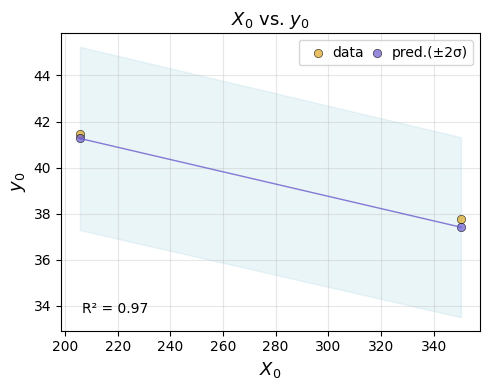

In [ ]:
em.plot_eval(gp_final)

#### 8 - History Matching
Once you have the final model, running history matching can improve your model.

- create a dictionary of your observations, this should match the output names of your simulator 
- create the history matching object 
- run history matching 


In [15]:
from autoemulate.history_matching import HistoryMatcher
# Define observed data with means and variances
observations = {
    'lv.P_i_min': (0.0, 0.1),   # Minimum of minimum LV pressure
    'lv.P_i_max': (20.0, 0.1),   # Maximum of minimum LV pressure
    'lv.P_i_mean': (15.0, 0.1),  # Mean of minimum LV pressure
    'lv.P_i_range': (15.0, 0.5), # Range of minimum LV pressure
    'lv.P_o_min': (1.0, 0.1),  # Minimum of maximum LV pressure
    'lv.P_o_max': (13.0, 0.1),  # Maximum of maximum LV pressure
    'lv.P_o_mean': (12.0, 0.1), # Mean of maximum LV pressure
    'lv.P_o_range': (20.0, 0.5)  # Range of maximum LV pressure
}


# Create history matcher
hm = HistoryMatcher(
    simulator=simulator,
    observations=observations,  # This needs both means and variances
    threshold=3.0
)

# Run history matching
all_samples, all_impl_scores, emulator = hm.run_history_matching(
    n_waves=20,
    n_samples_per_wave=10,
    use_emulator=True,
    initial_emulator=gp_final,
)

History Matching: 100%|██████████| 20/20 [00:00<00:00, 68.83wave/s, max_impl=2.88, min_impl=0.45, nroy=10, samples=10]                                                  


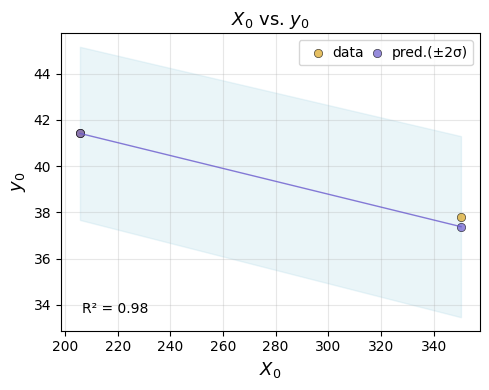

In [16]:
em.plot_eval(emulator)

#### 9 - use the interactive dashboard to inspect the results of history matching 

In [18]:
from autoemulate.history_matching_dashboard import HistoryMatchingDashboard
dashboard = HistoryMatchingDashboard(
    samples=all_samples,
    impl_scores=all_impl_scores,
    param_names=simulator.param_names,  # Use simulator.param_names instead of parameter_names
    output_names=simulator.output_names  # Use simulator.output_names instead of output_names
)
dashboard.display()

#### 10- Sensetivity Analysis 
Use AutoEmulate to perform sensitivity analysis. 

In [20]:
# Extract parameter names and bounds from the dictionary
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}


In [21]:
em.sensitivity_analysis(problem=problem)


,output,parameter,index,value,confidence
0,y1,ao.r,S1,0.000169,0.000016
1,y1,ao.c,S1,0.001094,0.000085
2,y1,art.r,S1,0.000377,0.000038
3,y1,art.c,S1,0.000201,0.000022
4,y1,ven.r,S1,0.000089,0.000009
...,...,...,...,...,...
115,y8,"(lv.E_pas, lv.v_ref)",S2,0.000555,0.005187
116,y8,"(lv.E_pas, lv.k_pas)",S2,0.000576,0.005269
117,y8,"(lv.E_act, lv.v_ref)",S2,-0.011519,0.063470
118,y8,"(lv.E_act, lv.k_pas)",S2,-0.015046,0.065612
